# Передбачення цін нерохумості за допомогою Регресії та Випадкового лісу
Метою цього проєкту є прогнозування цін на будинки з використанням одного базового алгоритму машинного навчання, лінійної регресії, та одного складного алгоритму, випадкового лісу. Ми також використаємо регресію з регуляризацією, таку як Ridge та Lasso, щоб спробувати покращити точність нашого прогнозування.

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline # щоб графіки відображались під коміркою з кодом де вони створюються

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Завантаження даних, їх пергляд та нормалізація

In [ ]:
df = pd.read_csv('KeggleHousePrices_train.csv')
print(df.shape)
# Поглянемо на датасет
df.head()
df.info()
# Знаходимо колонки з пропущеними значеннями та відсоток пропусків
df.isnull().sum()                                                     
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissvalCount'])

# Додаємо нову колонку до датафрейму та заповнюємо її відсотком пропущених значень
miss_val['Percent'] = miss_val.MissvalCount.apply(lambda x : '{:.2f}'.format(float(x)/df.shape[0] * 100)) 
miss_val = miss_val[miss_val.MissvalCount > 0]
miss_val
#Видалення колонок з великою кількістю пропусків
df = df.drop(['Fence', 'MiscFeature', 'PoolQC','FireplaceQu','Alley'], axis=1)
df.dropna(inplace=True)
df.shape

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

(455, 76)

У цьому блоці ми:

1.Завантажили датасет і перевірили його розмір.

2.Оглянули структуру даних: переглянули перші рядки, типи даних і наявність пропущених значень.

3.Знайшли колонки з пропущеними значеннями та обчислили відсоток відсутніх даних у кожній з них.

4.Видалили колонки з великою кількістю пропусків (Fence, MiscFeature, PoolQC, FireplaceQu, Alley).

5.Видалили всі рядки, в яких залишилися пропущені значення.

6.Після очищення ще раз перевірили розмір датасету.

# Графіки та дані
Давайте розглянемо розподіли даних ознак. Ми почнемо з цільової змінної, SalesPrice, щоб переконатися, що вона має нормальний розподіл. Це важливо, оскільки більшість алгоритмів машинного навчання роблять припущення, що дані мають нормальний розподіл. Коли дані відповідають нормальному розподілу, ми можемо робити висновки про популяцію, використовуючи аналітичні методи.

C:\Users\Олександр\AppData\Local\Temp\ipykernel_13076\897806631.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SalePrice'])


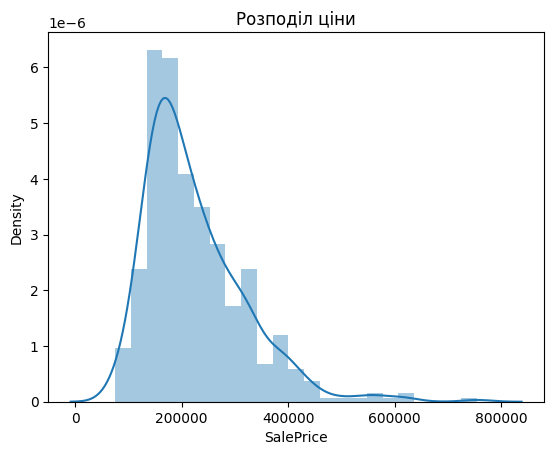

C:\Users\Олександр\AppData\Local\Temp\ipykernel_13076\897806631.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['SalePrice']))


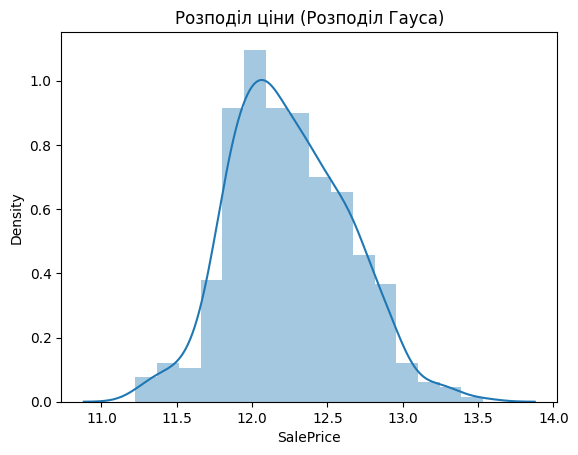

MiscVal          13.062759
PoolArea         12.559283
3SsnPorch         7.997668
BsmtFinSF2        6.127774
KitchenAbvGr      5.678190
EnclosedPorch     4.848662
BsmtHalfBath      4.290351
LotArea           4.082474
ScreenPorch       3.662176
TotalBsmtSF       2.592187
BsmtFinSF1        2.146508
MasVnrArea        2.128411
GrLivArea         1.895301
OpenPorchSF       1.667232
LotFrontage       1.623360
OverallCond       1.372570
1stFlrSF          1.343134
MSSubClass        1.106013
WoodDeckSF        0.857639
BsmtUnfSF         0.855804
2ndFlrSF          0.852999
TotRmsAbvGrd      0.736877
GarageArea        0.659486
HalfBath          0.472357
Fireplaces        0.335822
LogOfPrice        0.261798
BedroomAbvGr      0.252570
YrSold            0.158343
OverallQual       0.157532
BsmtFullBath      0.151391
MoSold            0.138804
Id                0.055842
LowQualFinSF      0.000000
GarageCars       -0.076837
FullBath         -0.508108
YearBuilt        -0.736565
GarageYrBlt      -0.764004
Y

In [4]:
# 1. Побудова графіка для початкової ціни
sns.distplot(df['SalePrice'])
plt.title('Розподіл ціни')
plt.show()

# 2. Побудова графіка після логарифмування
sns.distplot(np.log(df['SalePrice']))
plt.title('Розподіл ціни (Розподіл Гауса)')
plt.show()

# 3. Додаємо колонку з логарифмом ціни
df['LogOfPrice'] = np.log(df['SalePrice'])

# 4. Тепер можна видалити колонку з оригінальною ціною
df.drop(['SalePrice'], axis=1, inplace=True)

# 5. Обчислюємо скошеність тільки для числових ознак
skew_values = df.select_dtypes(include=['int64', 'float64']).skew().sort_values(ascending=False)
print(skew_values)


Значення, ближчі до нуля, менш перекошені. Результати показують, що деякі ознаки мають позитивну (правохвосту) або негативну (лівохвосту) перекошеність. Ми бачимо, що YearBuilt дещо перекошений вліво, але в цілому має нормальний розподіл, тоді як LotArea та PoolArea сильно перекошені вправо. Сильно перекошені розподіли в наборі даних можуть отримати користь від певних перетворень даних для покращення точності нашого прогнозування.

# Навчальний та тестовий набори даних
Перш ніж ми зможемо почати моделювати дані, нам потрібно розділити набір даних на навчальний та тестовий набори. Ми будемо навчати моделі на навчальному наборі та перевіряти їх на тестовому наборі. Згадайте, що в нашому наборі даних багато текстових ознак. Більшість моделей машинного навчання вимагають числових вхідних ознак. Оскільки процес перетворення текстових ознак на числове представлення є складним завданням, ми для простоти використовуватимемо лише числові ознаки в нашому прогнозуванні цін.

In [ ]:
# встановлюємо цільову змінну та предиктори
y = df.LogOfPrice  # змінна

# використовуємо тільки ті вхідні ознаки, що мають числовий тип даних 
df_temp = df.select_dtypes(include=["int64","float64"]) 
X = df_temp.drop(["LogOfPrice"],axis=1)  # predictors

# в даному прикладі я використовую 75% набору даних для навчання та залишу 25% для тестування
# розділяємо датасет на навчальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 3)

# Моделуювання
В ході курсової роботи побудуємо чотири моделі та оцінимо їхню продуктивність за метрикою R². Крім того, ми отримаємо уявлення про ознаки, які є сильними предикторами цін на будинки в нашому датасеті.

# Лінійна Регресія

In [ ]:
lr = LinearRegression()
# навчаємо оптимальну лінію лінійної регресії на тренувальних даних
lr.fit(X_train, y_train)
lr.fit(X_train, y_train)
# маючи нашу модель та її навчання, прогнозуємо значення y, використовуючи тестовий набір X_test
yr_hat = lr.predict(X_test)
# оцінюємо алгоритм за допомогою тестового набору
lr_score = lr.score(X_test, y_test)  # train test 
print(f"Точність (R² на тестовій вибірці): {lr_score * 100:.2f}%")
#перевірка наскільки добре спрацював метод розділення на навчальний та тестовий набори. Ми проведемо крос-валідацію, щоб побачити, чи модель не перенавчається:
# крос-валідація для знаходження валідаційної оцінки на кількох вибірках, автоматично виконує Kfold стратифікацію
lr_cv = cross_val_score(lr, X, y, cv = 5, scoring= 'r2')
print("Результати крос-валідації (R²):", lr_cv)
print(f"Середній R² (CV): {lr_cv.mean() * 100:.2f}%")

Точність (R² на тестовій вибірці): 85.84%
Результати крос-валідації (R²): [0.86179324 0.75396783 0.69743321 0.86432327 0.27489253]
Середній R² (CV): 69.05%


Схоже, що для цього набору даних, розділеного на навчальний та тестовий, модель не перенавчається (показники крос-валідації дуже близькі за значенням). Можливо, вона дещо перенавчена, але ми не можемо точно сказати це лише за метрикою R-квадрат. Якщо вона перенавчена, ми можемо застосувати деякі перетворення даних або інженерію ознак, щоб покращити її продуктивність. Але наша головна мета спочатку полягає в тому, щоб швидко перевірити кілька алгоритмів і пізніше налаштувати модель.

Щоб запобігти перенавчанню, яке може виникнути внаслідок простої лінійної регресії, ми можемо використовувати моделі регресії з регуляризацією. Давайте далі розглянемо Ridge та Lasso.

Параметр alpha в Ridge та Lasso регуляризує модель регресії. Алгоритми регресії з регуляризацією відрізняються від лінійної регресії тим, що намагаються штрафувати ті ознаки, які не є значущими в нашому прогнозуванні. Ridge намагатиметься зменшити їхній вплив (тобто стиснути їхні коефіцієнти), щоб оптимізувати всі вхідні ознаки. Lasso намагатиметься видалити незначущі ознаки, зробивши їхні коефіцієнти нульовими. Коротко кажучи, Lasso (L1-регуляризація) може усунути незначущі ознаки, таким чином виконуючи відбір ознак, тоді як Ridge (L2-регуляризація) не може цього зробити.

# Ridge регресія

In [7]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)

ridge_cv = cross_val_score(ridge, X, y, cv=5, scoring='r2')
print("Результати крос-валідації (R²):", ridge_cv)
print(f"Середній R² (CV): {ridge_cv.mean() * 100:.2f}%")


Результати крос-валідації (R²): [0.86157021 0.75386273 0.69706725 0.86647877 0.27327086]
Середній R² (CV): 69.04%


# Lasso регресія

In [8]:
lasso = Lasso(alpha = 0.001)
lasso.fit(X_train, y_train)

lasso_cv = cross_val_score(lasso, X, y, cv=5, scoring='r2')
print("Результати крос-валідації (R²):", lasso_cv)
print(f"Середній R² (CV): {lasso_cv.mean() * 100:.2f}%")

# Щоб визначити найкраще значення альфа(параметр регуляризації) для моделі, ми можемо використовувати GridSearch. 
# Ми б передали GridSearch діапазон значень альфа, і він би спробував їх усі в крос-валідації, щоб вивести найкраще для моделі.

Результати крос-валідації (R²): [0.86170089 0.7493793  0.6949451  0.87115145 0.25108923]
Середній R² (CV): 68.57%


# Випадковий ліс

Випадковий ліс є складним алгоритмом машинного навчання на основі дерев рішень. Він має алгоритм випадкового лісу для класифікації та регресії. Його продуктивність дещо краща, ніж у регресії. Подібно до регуляризації, ми можемо оптимізувати параметри моделі для найкращої продуктивності, використовуючи GridSearch.

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # навчаємо модель rfr
rfr_cv = cross_val_score(rfr,X, y, cv = 5, scoring = 'r2')
print(f"Середній R² (CV): {rfr_cv.mean() * 100:.2f}%")
rfr.feature_importances_

Середній R² (CV): 84.97%


array([4.92670742e-03, 2.69771499e-03, 1.54226568e-02, 3.89343216e-02,
       5.90143451e-01, 3.87355632e-03, 3.97083067e-02, 6.60010080e-03,
       1.66352768e-02, 2.00852528e-02, 2.36496663e-04, 1.29339732e-02,
       3.27299959e-02, 1.99679044e-02, 1.19081761e-02, 0.00000000e+00,
       7.73466539e-02, 1.32568359e-03, 1.27300398e-04, 1.80629553e-02,
       1.76856298e-03, 3.02464000e-03, 1.46416044e-04, 7.99074289e-03,
       5.32815335e-03, 4.94494555e-03, 1.26314654e-02, 2.36829253e-02,
       5.78704867e-03, 1.03308890e-02, 1.74468711e-04, 2.32774132e-04,
       5.83803695e-04, 1.88415432e-04, 5.46453881e-06, 7.26392752e-03,
       2.24887211e-03])

# Стекінг
Стекінг є ансамблевим методом машинного навчання, який комбінує прогнози декількох базових моделей (у цьому випадку Ridge та Випадковий ліс) за допомогою фінальної моделі (Лінійної регресії). Метою є покращення точності прогнозування шляхом використання сильних сторін різних алгоритмів. Його продуктивність може бути вищою, ніж у окремих базових моделей.

In [12]:
stack = StackingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=1.0)),
        ('rfr', RandomForestRegressor(n_estimators=100, random_state=42))
    ],
    final_estimator=LinearRegression(),
    cv=5
)

# тренування на навчальній вибірці
stack.fit(X_train, y_train)

# оцінка на тестовій вибірці
stack_score = stack.score(X_test, y_test)
print(f"R² на тестовій вибірці: {stack_score * 100:.2f}%")

# крос-валідація по всіх даних
stack_cv = cross_val_score(stack, X, y, cv=5, scoring='r2')
print(f"Середній R² (CV): {stack_cv.mean() * 100:.2f}%")


R² на тестовій вибірці: 87.12%
Середній R² (CV): 84.18%


# Візуалізація важливості ознак

['OverallQual', 'GrLivArea', 'YearBuilt', 'LotArea', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', '1stFlrSF', 'FullBath', 'MasVnrArea', 'LotFrontage', 'BsmtUnfSF', 'GarageCars', '2ndFlrSF', 'OpenPorchSF']


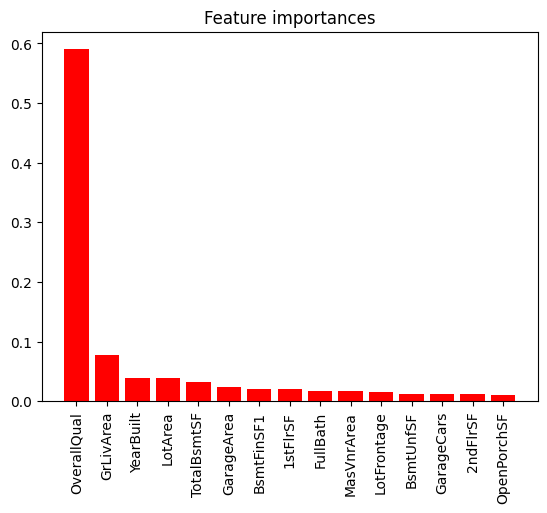

In [ ]:
importance = rfr.feature_importances_

# співставляємо значення важливості ознак з їх назвами
feature_importances = zip(importance, X.columns)

sorted_feature_importances = sorted(feature_importances, reverse = True)

top_15_predictors = sorted_feature_importances[0:15]
values = [value for value, predictors in top_15_predictors]
predictors = [predictors for value, predictors in top_15_predictors]
print(predictors)

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

# Висновки

У ході цього дослідження ансамблеві методи продемонстрували найкращу точність для прогнозування цін на житлову нерухомість. Зокрема, модель Стекінгу (Stacking) показала найвищий результат на тестовій вибірці з R²
близько 87.12%. Модель Випадкового лісу (Random Forest) також виявилася дуже точною, показавши найвищий середній R² при крос-валідації — близько 84.97% (у порівнянні з 84.18% у Стекінгу). Обидва ці ансамблеві методи значно перевершили простіші регресійні моделі (Лінійну, Ridge та Lasso), які показали середню точність близько 69% при крос-валідації.   

Аналіз важливості ознак за допомогою Випадкового лісу (оскільки стекинг не надає такої прямої інтерпретації за замовчуванням) показав, що загальна якість будинку (OverallQual) є найважливішим предиктором ціни. Наступними за важливістю йдуть житлова площа надземної частини будинку (GrLivArea) та рік побудови (YearBuilt). Ознака площі ділянки (LotArea) посіла четверте місце за важливістю.   

Машинне навчання — це ітеративний процес. Цей перший етап дослідження даних та оцінки моделей слугує гарною відправною точкою для швидкого отримання уявлень та створення першого прототипу моделі з високою точністю. Набір даних має значну структуру, і подальша робота може ще покращити продуктивність моделі прогнозування.

Можливі дослідження в майбутньому:

•Попередня обробка даних: Спробувати різні типи перетворень даних (наприклад, логарифмування інших ознак, стандартизація), щоб краще виявити структуру даних та потенційно підвищити точність моделі.

•Відбір та інженерія ознак: Провести ретельніший відбір ознак, можливо, видаливши сильно скорельовані (мультиколінеарність), або створити нові ознаки на основі наявних.

•Масштабування даних: Застосувати масштабування або нормалізацію до навчального набору даних, щоб зменшити вплив різних масштабів числових ознак. 
  
•Моделювання: Використовувати GridSearch для підбору оптимальних гіперпараметрів для моделей (включно з базовими моделями та мета-моделлю у Стекінгу). Спробувати інші алгоритми машинного навчання та більш складні ансамблеві методи.   